# Multiclass Regression 20 Newsgroups Dataset

### Installs and imports

In [1]:
%%capture
%pip install pandas
%pip install matplotlib
%pip install seaborn 
%pip install nltk
%pip install scikit-learn

import os
import tarfile
import seaborn as sns
import pandas as pd
import string
import re
import numpy as np
import nltk
import random
import csv

from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy.sparse import vstack 
from scipy.sparse import diags 
from sklearn.datasets import load_svmlight_file
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
#random seed for reproducibility
random.seed(42)

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# 20 newsgroups Dataset

The five chosen categories of newsgroups are the following:
    1. comp.graphics
    2. soc.religion.christian
    3. rec.sport.hockey
    4. sci.space
    5. talk.politics.guns

In [2]:
#importing the dataset and downloads 
nltk.download('stopwords')
nltk.download('punkt')

#fetching the dataset (all data)
all_newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
all_newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
print("Length of training data (before choosing 5 categories): " + str(len(all_newsgroups_train.data)))
print ("Length of test data (before choosing 5 categories): " + str(len(all_newsgroups_test.data)))

#Choosing 5 categories
chosen_categories = ['comp.graphics', 'soc.religion.christian', 'rec.sport.hockey', 'sci.space', 'talk.politics.guns']
newsgroups_train = fetch_20newsgroups(subset='train', categories=chosen_categories, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', categories=chosen_categories, remove=('headers', 'footers', 'quotes'))

print("Length of training data (after choosing 5 categories): " + str(len(newsgroups_train.data)))
print ("Length of test data (after choosing 5 categories): " + str(len(newsgroups_test.data)) + '\n')

#for data visualization purposes, printing the head of the dataset
newsgroups_train_df = pd.DataFrame({'text': newsgroups_train.data, 'category': newsgroups_train.target})
print("Train Data Frame")
display(newsgroups_train_df.head())

newsgroups_test_df = pd.DataFrame({'text': newsgroups_test.data, 'category': newsgroups_test.target})
print("Test Data Frame")
display(newsgroups_test_df.head())

#note the corresponding number values for each category
for index, category in enumerate(newsgroups_train.target_names):
    print(f'Category Number: {index} -> Category Name: {category}')

Length of training data (before choosing 5 categories): 11314
Length of test data (before choosing 5 categories): 7532
Length of training data (after choosing 5 categories): 2922
Length of test data (after choosing 5 categories): 1944

Train Data Frame


,text,category
0,,4
1,\n\nWho says there is no mineral rights to be ...,2
2,Everyone... Read this. If you have already se...,1
3,Hi!\n\nI need a Windows 3.1 driver for the Mat...,0
4,"\nPlease, define cell church. I missed it som...",3


Test Data Frame


,text,category
0,\tLots of house fires give off black sooty smo...,4
1,I would appreciate it if someone could volunte...,1
2,Does anyone know if any of Currier and Ives et...,0
3,\n\n\nThis is a heavily edited/modified versio...,0
4,"\nSpeaking of which, a paper was out a few yea...",2


Category Number: 0 -> Category Name: comp.graphics
Category Number: 1 -> Category Name: rec.sport.hockey
Category Number: 2 -> Category Name: sci.space
Category Number: 3 -> Category Name: soc.religion.christian
Category Number: 4 -> Category Name: talk.politics.guns


Now that we have selected a subset of the data, we will visualize its distribution to ensure the categories of news are relatively well balanced. 

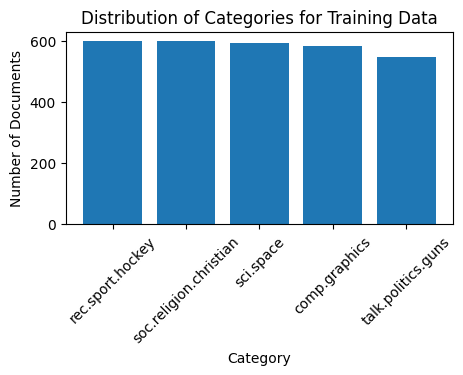

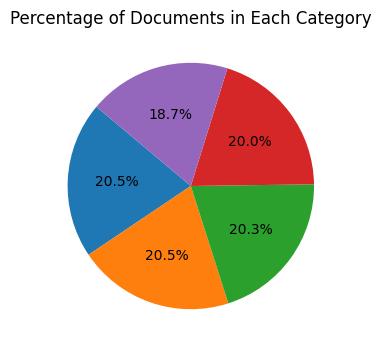

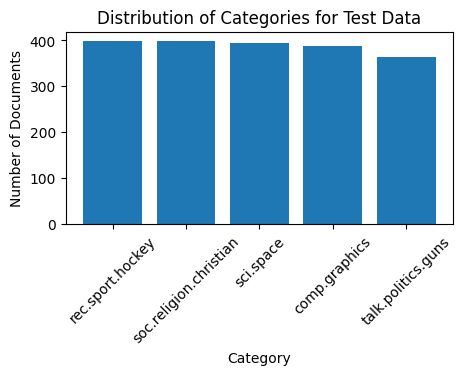

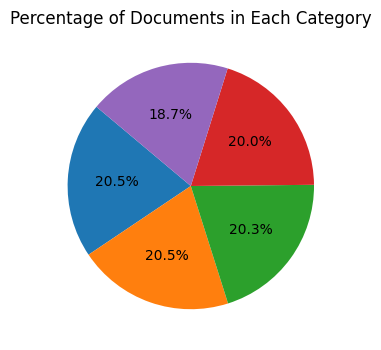

In [3]:
#visualize the distribution of categories selected through a bar graph

#count the number of documents in each category
category_counts = newsgroups_train_df['category'].value_counts()

#convert the categories numbers to their names
category_names = [newsgroups_train.target_names[i] for i in category_counts.index]

#calculate the category percentages
category_percentages = category_counts / category_counts.sum() * 100

#plot the distribution 
plt.figure(figsize=(5,2.5))
plt.bar(category_names, category_counts)
plt.title('Distribution of Categories for Training Data')
plt.xlabel('Category')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45)
plt.show()

# Plot a pie chart
plt.figure(figsize=(4,4))
plt.pie(category_percentages, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Documents in Each Category')
plt.show()

#same steps for the test data
category_counts = newsgroups_test_df['category'].value_counts()
category_names = [newsgroups_test.target_names[i] for i in category_counts.index]
category_percentages = category_counts / category_counts.sum() * 100

plt.figure(figsize=(5, 2.5))
plt.bar(category_names, category_counts)
plt.title('Distribution of Categories for Test Data')
plt.xlabel('Category')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45)
plt.show()

# Plot a pie chart
plt.figure(figsize=(4, 4))
plt.pie(category_percentages, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Documents in Each Category')
plt.show()

Now, we have seen our data in both training and testing is well balanced. So we can continue with further preprocessing steps. 

Note the folowing numbers and their associated category names:

Category Number: 0 -> Category Name: comp.graphics
Category Number: 1 -> Category Name: rec.sport.hockey
Category Number: 2 -> Category Name: sci.space
Category Number: 3 -> Category Name: soc.religion.christian
Category Number: 4 -> Category Name: talk.politics.guns

## Data Preprocessing

Several preprocessing steps are required before training our model. We will lowercase the entries, remove punctuation, special characters and numbers as well as double spaces. We will then remove stopwords and filter out any empty entries. 

In [4]:
#Preprocessing steps ============
#TRAINING DATA =============================
#lowercase the entries
newsgroups_train.data = [text.lower() for text in newsgroups_train.data]
#regex to remove tags, etc.
newsgroups_train.data = [re.sub(r'(<br\s*/>\s*)+|(/)|(\n)|(-)', '', text) for text in newsgroups_train.data]
#removing punctuation
newsgroups_train.data = [text.translate(str.maketrans('', '', string.punctuation)) for text in newsgroups_train.data]
#removing numbers and any other special characters
newsgroups_train.data = [re.sub(r'[^a-z\s]', '', text) for text in newsgroups_train.data]
#remove any double spaces
newsgroups_train.data = [re.sub(r'\s+', ' ', text) for text in newsgroups_train.data]

# Filter out empty entries and update both data and target
filtered_data = []
filtered_target = []
for text, target in zip(newsgroups_train.data, newsgroups_train.target):
    if text.strip():
        filtered_data.append(text)
        filtered_target.append(target)

newsgroups_train.data = filtered_data
newsgroups_train.target = np.array(filtered_target)

#removing stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    entry_nostopwords = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(entry_nostopwords)

#call remove_stopwords function
newsgroups_train.data = [remove_stopwords(entry) for entry in newsgroups_train.data]

# Create a DataFrame for visualization
newsgroups_train_df_cleaned = pd.DataFrame({'entry (Data)': newsgroups_train.data, 'target': newsgroups_train.target})
display(newsgroups_train_df_cleaned.head())

#TEST DATA =============================
#lowercase the entries
newsgroups_test.data = [text.lower() for text in newsgroups_test.data]
#regex to remove tags, etc.
newsgroups_test.data = [re.sub(r'(<br\s*/>\s*)+|(/)|(\n)|(-)', '', text) for text in newsgroups_test.data]
#removing punctuation
newsgroups_test.data = [text.translate(str.maketrans('', '', string.punctuation)) for text in newsgroups_test.data]
#removing numbers and any other special characters
newsgroups_test.data = [re.sub(r'[^a-z\s]', '', text) for text in newsgroups_test.data]
#remove any double spaces
newsgroups_test.data = [re.sub(r'\s+', ' ', text) for text in newsgroups_test.data]

# Filter out empty entries and update both data and target
filtered_data = []
filtered_target = []
for text, target in zip(newsgroups_test.data, newsgroups_test.target):
    if text.strip():
        filtered_data.append(text)
        filtered_target.append(target)
        
newsgroups_test.data = filtered_data
newsgroups_test.target = np.array(filtered_target)

#call remove_stopwords 
newsgroups_test.data = [remove_stopwords(entry) for entry in newsgroups_test.data]

y_newsgroups_train = newsgroups_train.target

,entry (Data),target
0,says mineral rights given says un usgovernment...,2
1,everyone read already sent predictions pleasec...,1
2,hii need windows driver matrox pg cvsvga card ...,0
3,please define cell church missed somewhere pas...,3
4,ive running daily summary randy weaverkevinhar...,4


### Converting text to vectors 

Using Count Vectorizer we will count the occurences of each token in each document. 
We used a minimum threshold of 0.01 and a maximum threshold of 0.5.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(min_df= 0.01, max_df= 0.5)
X_train_counts = count_vect.fit_transform(newsgroups_train.data)

print("Number of unique words in the training data: " + str(X_train_counts.shape[1]))
print("The shape of the training data: " + str(X_train_counts.shape))

#perform the same on the test data
X_test_counts = count_vect.transform(newsgroups_test.data)

print("Number of unique words in the test data: " + str(X_test_counts.shape[1]))
print("The shape of the test data: " + str(X_test_counts.shape))


Number of unique words in the training data: 1267
The shape of the training data: (2852, 1267)
Number of unique words in the test data: 1267
The shape of the test data: (1888, 1267)


Now, we will use tf-idf so that we can remove the potential issue of logner documents having a higher average count for words than shorter documents. 

Tf-idf will downscale the weight of words that occur in many documents are are less informative.

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer(use_idf=True)
X_train_newsgroups = tfidf_transformer.fit_transform(X_train_counts)

#perform same on test dataset
X_test_newsgroups = tfidf_transformer.fit_transform(X_test_counts)

print("The shape of the training data after TF-IDF: " + str(X_train_newsgroups.shape))

The shape of the training data after TF-IDF: (2852, 1267)


## Using Mutual Information (MI) to select features

We will use mutual informations cores to determine which features are most important for making predictions. This will tell us the words that are most important in predicting the category of news.

One hot encoding

In [7]:
from sklearn.preprocessing import OneHotEncoder

# Before encoding
print("The shape of the training target: " + str(newsgroups_train.target.shape))
print("Matrix of y_train before one hot encoding: ", newsgroups_train.target)

onehot_encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = onehot_encoder.fit_transform(newsgroups_train.target.reshape(-1, 1))

# After encoding
print("The shape of the one-hot encoded training target: " + str(y_train_onehot.shape))
print("Matrix of y_train after one hot encoding: \n", y_train_onehot)

#perform the same on the test dataset
y_test_onehot = onehot_encoder.fit_transform(newsgroups_test.target.reshape(-1, 1))

#update variables
y_train_newsgroups = y_train_onehot
y_test_newsgroups = y_test_onehot

The shape of the training target: (2852,)
Matrix of y_train before one hot encoding:  [2 1 0 ... 0 2 0]
The shape of the one-hot encoded training target: (2852, 5)
Matrix of y_train after one hot encoding: 
 [[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [8]:
from sklearn.metrics import mutual_info_score

#number of classes
num_classes = len(newsgroups_train.target_names)

#number of features
num_features = X_train_counts.shape[1]

top_features_classes = {}

for y_index, class_name in enumerate(newsgroups_train.target_names):
    #Debugging purposes
    #print("Shape of X_train_counts:", X_train_counts.shape)
    #print("Shape of y_train_onehot:", y_train_onehot.shape)
    
    # Create a binary array for the current class
    y_bin = y_train_onehot[:, y_index]

    # Calculate MI scores for each feature
    mi_scores = [mutual_info_score(X_train_counts[:, i].toarray().flatten(), y_bin) for i in range(num_features)]


    # Get the top 100 features
    top_indices = np.argsort(mi_scores)[::-1][:100]
    
    # Get the feature names and scores
    top_features = [count_vect.get_feature_names_out()[i] for i in top_indices]
    max_mi_scores = [mi_scores[i] for i in top_indices]

    # storing the top 100 features
    top_features_classes[class_name] = list(zip(top_features, max_mi_scores))

# # for vizualization purposes, print the top 100 features for each class
# for class_name, features in top_features_classes.items():
#     print(f"Top 100 features for {class_name}:")
#     for feature, score in features:
#         print(f"{feature}: {score}")
#     print()
    
# convert to a data fram
top_features_df = pd.DataFrame(top_features_classes)

#displaying the top 10 words for each news category
display(top_features_df.head(10))

,comp.graphics,rec.sport.hockey,sci.space,soc.religion.christian,talk.politics.guns
0,"(graphics, 0.05564599935504441)","(team, 0.08100651340947392)","(space, 0.09053608419504511)","(god, 0.14064739938889032)","(gun, 0.07559973199004538)"
1,"(file, 0.028441803682253256)","(hockey, 0.07172721946525026)","(orbit, 0.03870713636497573)","(jesus, 0.08196727800351067)","(guns, 0.04962181814220196)"
2,"(files, 0.027830440242797783)","(game, 0.06913957799375037)","(nasa, 0.03748733388512096)","(bible, 0.07000155951915363)","(weapons, 0.04137602748239471)"
3,"(image, 0.025486550770752736)","(nhl, 0.05090320041730769)","(launch, 0.03417845942894569)","(christians, 0.06311145196400059)","(firearms, 0.03198836802658515)"
4,"(people, 0.022583423418649162)","(games, 0.050678071000647376)","(moon, 0.031035214424032308)","(christ, 0.06095651368159775)","(crime, 0.03074138379174572)"
5,"(software, 0.02034375245378128)","(season, 0.049832720178183736)","(shuttle, 0.030041158794407323)","(church, 0.05892034328496892)","(fbi, 0.02756105814055943)"
6,"(format, 0.01924895171675725)","(play, 0.04872171525170221)","(lunar, 0.02498452653755622)","(christian, 0.05214186124062077)","(fire, 0.027272140095177675)"
7,"(god, 0.018742089789155966)","(players, 0.04434960071858796)","(spacecraft, 0.022230117196843868)","(faith, 0.04967079604001103)","(police, 0.025892293214505136)"
8,"(vga, 0.018344192279169145)","(league, 0.04430022307779521)","(flight, 0.02036594828013598)","(gods, 0.047755437120394234)","(criminals, 0.025828709545280378)"
9,"(ftp, 0.017093370713676507)","(teams, 0.04296167749007862)","(solar, 0.019910741880903943)","(christianity, 0.03988668581174554)","(weapon, 0.025610014484228664)"


In [10]:
# Take the union of the top 100 features of each class
top_features_union = set().union(*top_features_classes.values())

print("Number of unique words in the top 100 features for each class: " + str(len(top_features_union)))

# Convert the set to a list
top_features_union_list = list(top_features_union)


Number of unique words in the top 100 features for each class: 500


## Implementing the Multiclass Regression model

In [11]:
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    # modify it to add stopping criteria (what can you think of?)
    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.005, niter=100):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            else:
                print(f"iter {i}: {loss_train:.3f}")
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()


## Splitting the dataset into training, testing and validation sets

The variables we will use for the 20 news dataset are the following:

X_train_newsgroups
y_train_newsgroups
X_validate_newsgroups
y_validate_newsgroups
X_test_newsgroups
y_test_newsgroups

In [12]:
from sklearn.model_selection import train_test_split

X_train_newsgroups, X_validate_newsgroups, y_train_newsgroups, y_validate_newsgroups = train_test_split(X_train_newsgroups, y_train_newsgroups, test_size = 0.3, random_state = 5, shuffle = True)

#print the shapes of all the sets
print("The shape of the training set: " + str(X_train_newsgroups.shape))
print("The shape of the validation set: " + str(X_validate_newsgroups.shape))
print("The shape of the test set: " + str(X_test_counts.shape))


The shape of the training set: (1996, 1267)
The shape of the validation set: (856, 1267)
The shape of the test set: (1888, 1267)


### Evaluation: Multi-class prediction classification accuracy 

First, we will fit the model and ensure there is no overfitting. 

Gradient for multiclass: 1.2921402459219335e-09
iter 0: 3219.774; 1375.847
iter 1: 3143.938; 1347.587
iter 2: 3070.725; 1320.333
iter 3: 3000.115; 1294.075
iter 4: 2932.080; 1268.803
iter 5: 2866.581; 1244.499
iter 6: 2803.572; 1221.146
iter 7: 2742.997; 1198.719
iter 8: 2684.795; 1177.194
iter 9: 2628.897; 1156.543
iter 10: 2575.231; 1136.736
iter 11: 2523.719; 1117.744
iter 12: 2474.281; 1099.533
iter 13: 2426.838; 1082.073
iter 14: 2381.306; 1065.332
iter 15: 2337.605; 1049.278
iter 16: 2295.652; 1033.879
iter 17: 2255.370; 1019.106
iter 18: 2216.679; 1004.929
iter 19: 2179.505; 991.318
iter 20: 2143.775; 978.248
iter 21: 2109.419; 965.690
iter 22: 2076.369; 953.620
iter 23: 2044.562; 942.014
iter 24: 2013.936; 930.848
iter 25: 1984.432; 920.102
iter 26: 1955.995; 909.753
iter 27: 1928.572; 899.783
iter 28: 1902.114; 890.172
iter 29: 1876.573; 880.904
iter 30: 1851.904; 871.961
iter 31: 1828.064; 863.328
iter 32: 1805.015; 854.989
iter 33: 1782.718; 846.932
iter 34: 1761.137; 839.14

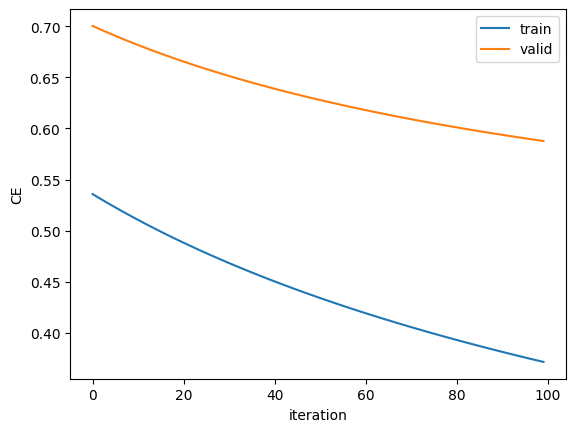

In [13]:
#make sure we are dealing with dense arrays 
X_train_newsgroups = X_train_newsgroups.toarray()
X_validate_newsgroups = X_validate_newsgroups.toarray()
X_test_newsgroups = X_test_newsgroups.toarray()

#create the model
model = Multinomial_logistic(nFeatures=X_train_newsgroups.shape[1], nClasses=y_train_onehot.shape[1])

#checking the gradient
print("Gradient for multiclass: " + str(model.check_grad(X_train_newsgroups, y_train_newsgroups)))

#fit the model 
model.fit(X_train_newsgroups, y_train_newsgroups, X_valid=X_validate_newsgroups, y_valid=y_validate_newsgroups)

ce_train, ce_valid = model.fit(X_train_newsgroups, y_train_newsgroups, X_valid=X_validate_newsgroups, y_valid=y_validate_newsgroups)
#plot a figure to ensure no overfitting 
plt.clf()
plt.plot(ce_train/X_train_newsgroups.shape[0], label='train')
plt.plot(ce_valid/X_validate_newsgroups.shape[0], label='valid')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
# plt.show()
plt.savefig("training_ce.png", bbox_inches="tight", dpi=300)


We have verified from the above plot that both training and validation error curves are continuing to decrease for all the iterations. Therefore, we can conlcude there are no errors in overfitting and can evaluate our model.

#### Evaluating the Classification Accuracy 

In [14]:
def evaluate(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy

In [ ]:
train_accuracy = evaluate(model.predict(X_train_newsgroups), y_train_newsgroups)
valid_accuracy = evaluate(model.predict(X_validate_newsgroups), y_validate_newsgroups)
test_accuracy = evaluate(model.predict(X_test_newsgroups), y_test_newsgroups)

print("Training accuracy : " + str(train_accuracy))
print("Validation accruacy : " + str(valid_accuracy))
print("Test accuracy : " + str(test_accuracy))

multiclass_accuracy = test_accuracy

### Comparing multi-label classification with Decision Tree 

We are going to begin by comparing DT performance and our multi-class model with default hyperparameters and then will perform optimizations for tree depth and classification hyperparameters.

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

#make a pipeline for decision tree 

pipeline_dt = Pipeline([
    ('clf', DecisionTreeClassifier()),
])

pipeline_dt.fit(X_train_newsgroups, y_train_newsgroups)

y_pred_dt_newsgroups = pipeline_dt.predict(X_test_newsgroups)

accuracy_dt = accuracy_score(y_test_newsgroups, y_pred_dt_newsgroups)

newsgroups_accuracy_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Multi-class'],
    'Accuracy': [accuracy_dt, multiclass_accuracy]
})

#display the df
display(newsgroups_accuracy_df)


,Model,Accuracy
0,Decision Tree,0.664725
1,Multi-class,0.812500


### Experimenting with max depth optimization

Now, we will perform the same comparison but with max depth optimization. 

In [17]:
# Initialize maximum accuracy and corresponding depth
max_accuracy_dt = 0
best_depth = 0

#increments of max depth 
for i in [5,10,20,30,40,50,75,100,225,500,1000,2225,3000,5000]:
    pipeline_dt = Pipeline([
        ('clf', DecisionTreeClassifier(max_depth=i)),
    ])

    pipeline_dt.fit(X_train_newsgroups, y_train_newsgroups)

    y_pred_dt_newsgroups = pipeline_dt.predict(X_test_newsgroups)

    accuracy_dt = accuracy_score(y_test_newsgroups, y_pred_dt_newsgroups)
    
    # Update max accuracy and depth if current accuracy is greater
    if accuracy_dt > max_accuracy_dt:
        max_accuracy_dt = accuracy_dt
        best_depth = i

print(f"The maximum accuracy is {max_accuracy_dt} at depth {best_depth}")

The maximum accuracy is 0.663135593220339 at depth 3000


### Task 3: Running Experiments

##### Comparing the accuracy of the multiclass model with DT as a function of the size of the dataset.

In [ ]:
#make a list of training sizes to test
training_sizes = [0.2, 0.4, 0.6, 0.8]

#initialize the list of accuracies
mlr_accuracies = []
dt_accuracies = []

#loop through the training sizes
for size in training_sizes:
    #split the data
    X_train_newsgroups, X_validate_newsgroups, y_train_newsgroups, y_validate_newsgroups = train_test_split(X_train_newsgroups, y_train_newsgroups, test_size = size, random_state = 5, shuffle = True)
    
    #create the model
    model = Multinomial_logistic(nFeatures=X_train_newsgroups.shape[1], nClasses=y_train_onehot.shape[1])
    
    #fit the model
    model.fit(X_train_newsgroups, y_train_newsgroups, X_valid=X_validate_newsgroups, y_valid=y_validate_newsgroups)
    
    #get the accuracy
    train_accuracy = evaluate(model.predict(X_train_newsgroups), y_train_newsgroups)
    valid_accuracy = evaluate(model.predict(X_validate_newsgroups), y_validate_newsgroups)
    test_accuracy = evaluate(model.predict(X_test_newsgroups), y_test_newsgroups)
    
    #append the accuracy to the list
    mlr_accuracies.append(test_accuracy)
    
    #create the pipeline for decision tree
    pipeline_dt = Pipeline([
        ('clf', DecisionTreeClassifier(max_depth=best_depth)),
    ])
    
    #fit the model
    pipeline_dt.fit(X_train_newsgroups, y_train_newsgroups)
    
    #get the accuracy
    y_pred_dt_newsgroups = pipeline_dt.predict(X_test_newsgroups)
    accuracy_dt = accuracy_score(y_test_newsgroups, y_pred_dt_newsgroups)
    
    #append the accuracy to the list
    dt_accuracies.append(accuracy_dt)
    
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, mlr_accuracies, marker='o', label='Multinomial Logistic Regression')
plt.plot(training_sizes, dt_accuracies, marker='s', label='Decision Tree')
plt.title('Model Accuracy as a Function of Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.xticks(training_sizes, [f'{int(size*100)}%' for size in training_sizes])
plt.legend()
plt.grid(True)
plt.show()

x = np.arange(len(training_sizes))  
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, mlr_accuracies, width, label='Multiclass Regression')
rects2 = ax.bar(x + width/2, dt_accuracies, width, label='Decision Tree')

ax.set_xlabel('Training Data Size')
ax.set_ylabel('Accuracy')
ax.set_title('Classification Accuracies of MLR and DT on Test Data')
ax.set_xticks(x)
ax.set_xticklabels([f'{int(size*100)}%' for size in training_sizes])
ax.legend()

plt.show()

iter 0: 2552.830; 637.578
iter 1: 2503.482; 626.521
iter 2: 2455.525; 615.785
iter 3: 2408.956; 605.368
iter 4: 2363.763; 595.267
iter 5: 2319.935; 585.478
iter 6: 2277.456; 575.997
iter 7: 2236.305; 566.818
iter 8: 2196.459; 557.937
iter 9: 2157.893; 549.346
iter 10: 2120.576; 541.038
iter 11: 2084.479; 533.007
iter 12: 2049.568; 525.244
iter 13: 2015.809; 517.742
iter 14: 1983.165; 510.492
iter 15: 1951.602; 503.486
iter 16: 1921.083; 496.715
iter 17: 1891.570; 490.172
iter 18: 1863.027; 483.848
iter 19: 1835.418; 477.735
iter 20: 1808.707; 471.824
iter 21: 1782.861; 466.108
iter 22: 1757.844; 460.579
iter 23: 1733.623; 455.230
iter 24: 1710.168; 450.054
iter 25: 1687.446; 445.043
iter 26: 1665.428; 440.191
iter 27: 1644.085; 435.491
iter 28: 1623.389; 430.938
iter 29: 1603.315; 426.524
iter 30: 1583.836; 422.245
iter 31: 1564.929; 418.096
iter 32: 1546.569; 414.070
iter 33: 1528.736; 410.163
iter 34: 1511.406; 406.370
iter 35: 1494.561; 402.687
iter 36: 1478.181; 399.108
iter 37: 14

##### Heatmap for top 5 most positive features for each class. 

In [ ]:
#list of classes 
class_order = ['comp.graphics', 'rec.sport.hockey', 'sci.space', 'soc.religion.christian', 'talk.politics.guns']

rows_list = []

# get the top 5 features for each class and append them 
for class_name in class_order:
    features = top_features_classes[class_name][:5]
    for feature, score in features:
        rows_list.append({'Feature': feature, 'Class': class_name, 'Score': score})

features_df = pd.DataFrame(rows_list)

features_df['Class'] = pd.Categorical(features_df['Class'], categories=class_order, ordered=True)

features_df = features_df.sort_values(by='Class')

pivoted_df = features_df.pivot(index='Feature', columns='Class', values='Score')

# Fill in any blanks with 0
pivoted_df = pivoted_df.fillna(0)

plt.figure(figsize=(10, 10))
sns.heatmap(pivoted_df, annot=True, cmap='YlGnBu', linewidths=.5)
plt.title('Top 5 Features Heatmap by Class')
plt.xlabel('Class')
plt.ylabel('Feature')
plt.show()
